In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
import scipy.fft as fft
import scipy.linalg as scipyla
import os
from IPython.display import Audio
from IPython.display import display
import sys
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from tqdm import tqdm
import parselmouth
from parselmouth.praat import call
np.set_printoptions(threshold=sys.maxsize)
print("Libraries Imported")

C:\Users\diego\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\diego\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\diego\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Libraries Imported


In [2]:
# Helper Functions
def getCoeff(timeSignal):
    acSum = np.zeros(13)
    for i in range(1,14):
        acSum[i-1] = np.sum(timeSignal[:len(timeSignal)-i]*timeSignal[i:])
    R = scipyla.toeplitz(acSum,acSum)
    r = acSum[0:13]
    predCoeff = np.matmul(-np.linalg.inv(R),r)
    return predCoeff

def calculateHE(peSignal,startBand,endBand):
    freqSignal = fft.fft(peSignal)
    bandSig = freqSignal[startBand:endBand]
    hannWindow = signal.get_window("hann", len(bandSig))
    bandSighann = bandSig*hannWindow
    doubleSig = np.concatenate((bandSighann,np.zeros(len(bandSighann))))
    timeSig = fft.ifft(doubleSig)
    hilbertEnvelope = np.abs(timeSig)
    return hilbertEnvelope

def calculateGNE(HE1, HE2, delay=3):
    maxCorr = -1
    optimal_delay = 0
    for d in range(-delay,delay+1):
        corr = np.corrcoef(HE1,np.roll(HE2,d))[0][1]
        if corr > maxCorr:
            maxCorr = corr
            optimal_delay = d
    return maxCorr

def extractFeatures(path):
    # Import Audio
    timeSignal, samplingRate = librosa.load(path,sr=None)
    signalSound = parselmouth.Sound(timeSignal, sampling_frequency=samplingRate)
    pointProcess = parselmouth.praat.call(signalSound, "To PointProcess (periodic, cc)", 75, 500) # turns signal to points
    
    # f0
    pitch = signalSound.to_pitch()
    f0 = pitch.selected_array['frequency']
    f0Mean = np.mean(np.nonzero(f0))
    
    #Formants
    formants = signalSound.to_formant_burg(time_step=0.010, maximum_formant=5000)
    f1List, f2List, f3List = [], [], []
    for t in formants.ts():
        f1 = formants.get_value_at_time(1, t)
        f2 = formants.get_value_at_time(2, t)
        f3 = formants.get_value_at_time(3, t)
        if np.isnan(f1): f1 = 0
        if np.isnan(f2): f2 = 0
        if np.isnan(f3): f3 = 0
        f1List.append(f1)
        f2List.append(f2)
        f3List.append(f3)
     
    f0 = np.array(f0)
    f1 = np.array(f1List)
    f2 = np.array(f2List)
    f3 = np.array(f3List)
    
    # Obtain nonzero Values
    f1 = f1[np.nonzero(f0[:len(f1)])]
    f2 = f2[np.nonzero(f0[:len(f2)])]
    f3 = f3[np.nonzero(f0[:len(f3)])]
    f0 = f0[np.nonzero(f0)]
    
    # Average freq for Formant
    f1Mean = np.mean(f1)
    f2Mean = np.mean(f2)
    f3Mean = np.mean(f3)
    
    # Forman Correlation Coeff
    allFormants = np.column_stack((f1, f2, f3))
    corrMatrix = np.corrcoef(allFormants, rowvar=False)
    f1f2 = corrMatrix[0][1]
    f3f1 = corrMatrix[2][0]
    f2f3 = corrMatrix[1][2]
    
    # Jitter
    localJitter = parselmouth.praat.call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = parselmouth.praat.call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)

    # Shimmer
    localShimmer = parselmouth.praat.call([signalSound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = parselmouth.praat.call([signalSound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    # HNR
    harmonicity = parselmouth.praat.call(signalSound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0) # Obtain harmonicity of signal
    hnr = parselmouth.praat.call(harmonicity, "Get mean", 0, 0) # calculates the avg HNR from harmonicity
    hnrdB = 10*np.log10(hnr)
    
    # GNE
    # Down Sample
    resamplingFactor = 10000/samplingRate
    downsampledSignal = signal.resample(timeSignal,int(len(timeSignal)*resamplingFactor))
    downSamplingRate = int(samplingRate*resamplingFactor)

    # Inverse Filter
    windowLen = 0.03
    shiftLen = 0.01
    windowSamples = int(windowLen*downSamplingRate)
    shiftSamples = int(shiftLen*downSamplingRate)

    peSignal = np.zeros(len(downsampledSignal))
    for i in range(0,len(downsampledSignal)-windowSamples,shiftSamples):
        frame = downsampledSignal[i:i+windowSamples]
        hannWindow = signal.get_window("hann", len(frame))
        frameWithhann = frame*hannWindow
        predictedSignal = np.zeros(len(frameWithhann))
        predCoeff = getCoeff(frameWithhann)
        for a in range(1,len(predCoeff)+1):
            predictedSignal += (predCoeff[a-1]*np.roll(frameWithhann, i))
        peSignal[i:i+windowSamples] = frameWithhann-predictedSignal 

    # Hilbert Envelopes
    hilbertEnvelopes = []
    bands = [[0,1000],[1000,2000],[2000,3000]]
    hilbertEnvelopes.append(calculateHE(peSignal,bands[0][0],bands[0][1]))
    hilbertEnvelopes.append(calculateHE(peSignal,bands[1][0],bands[1][1]))
    hilbertEnvelopes.append(calculateHE(peSignal,bands[2][0],bands[2][1]))

    gne = max(calculateGNE(hilbertEnvelopes[0],hilbertEnvelopes[1],3),
              calculateGNE(hilbertEnvelopes[1],hilbertEnvelopes[2],3))

    return f0Mean, localJitter, localabsoluteJitter*(10**6), localShimmer, localdbShimmer, hnrdB, gne, f1f2, f3f1, f2f3, f1Mean, f2Mean, f3Mean

In [3]:
# Retrieve data from Excel
dataframe = pd.read_csv("data_with_path.csv")
print(dataframe)

      Gender Is_dysarthria                                           Wav_path  \
0     Female            No  /kaggle/input/dysarthria-and-nondysarthria-spe...   
1     Female            No  /kaggle/input/dysarthria-and-nondysarthria-spe...   
2     Female            No  /kaggle/input/dysarthria-and-nondysarthria-spe...   
3     Female            No  /kaggle/input/dysarthria-and-nondysarthria-spe...   
4     Female            No  /kaggle/input/dysarthria-and-nondysarthria-spe...   
...      ...           ...                                                ...   
8209    Male           Yes  /kaggle/input/dysarthria-and-nondysarthria-spe...   
8210    Male           Yes  /kaggle/input/dysarthria-and-nondysarthria-spe...   
8211    Male           Yes  /kaggle/input/dysarthria-and-nondysarthria-spe...   
8212    Male           Yes  /kaggle/input/dysarthria-and-nondysarthria-spe...   
8213    Male           Yes  /kaggle/input/dysarthria-and-nondysarthria-spe...   

                           

In [4]:
# Turn data into arrays
genders = dataframe["Gender"].values
isDysarthria = dataframe["Is_dysarthria"].values
wavPath = dataframe["Wav_path"].values
prompts = dataframe["Prompts"].values

# Remove bad inputs
genders = genders[(prompts != "xxx\n") & (prompts != "[relax your mouth in its normal position]") & (prompts != "[relax your mouth in its normal position]\n")]
isDysarthria = isDysarthria[(prompts != "xxx\n") & (prompts != "[relax your mouth in its normal position]") & (prompts != "[relax your mouth in its normal position]\n")]
wavPath = wavPath[(prompts != "xxx\n") & (prompts != "[relax your mouth in its normal position]") & (prompts != "[relax your mouth in its normal position]\n")]
prompts = prompts[(prompts != "xxx\n") & (prompts != "[relax your mouth in its normal position]") & (prompts != "[relax your mouth in its normal position]\n")]

# Fix path for wav files
for i in range(len(wavPath)):
    index = wavPath[i].rfind("Dysarthria and Non Dysarthria")
    wavPath[i] = wavPath[i][index:]

In [5]:
# Check if file exists
workdir = os.getcwd()
noExist = []
samples = np.zeros(len(wavPath))
for i in range(len(wavPath)):
    path = workdir + "/" + wavPath[i]
    try:
        timeSignal, samplingRate = librosa.load(path)
        if (len(timeSignal)/samplingRate) < 0.5 or (len(timeSignal)/samplingRate > 10):
            noExist.append(0)
            continue
        noExist.append(1)
        samples[i] = len(timeSignal)
    except FileNotFoundError:
        noExist.append(0)

C:\Users\diego\AppData\Local\Temp\ipykernel_23416\3085708511.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  timeSignal, samplingRate = librosa.load(path)
C:\Users\diego\anaconda3\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [6]:
# Remove files that don't exist
noExist = np.array(noExist)
genders = genders[noExist == 1]
isDysarthria = isDysarthria[noExist == 1]
wavPath = wavPath[noExist == 1]
prompts = prompts[noExist == 1]
samples = samples[noExist == 1]

In [7]:
# Extract Features
fundamentalFreqs =[]
jitters = []
shimmers = []
HNRs = []
GNEs = []
f1f2Coeffs = []
f3f1Coeffs = []
f2f3Coeffs = []
f1Avg = []
f2Avg = []
f3Avg = []
workdir = os.getcwd()
for i in tqdm(range(len(wavPath)), desc=f"Retrieving Features"):
    path = workdir + "/" + wavPath[i]
    fo, jp, jms, shp, shdB, hnrdB, gne, f1f2, f3f1, f2f3, f1, f2, f3 = extractFeatures(path)
    fundamentalFreqs.append(fo)
    jitters.append([jp,jms])
    shimmers.append([shp,shdB])
    HNRs.append(hnrdB)
    GNEs.append(gne)
    f1f2Coeffs.append(f1f2)
    f3f1Coeffs.append(f3f1)
    f2f3Coeffs.append(f2f3)
    f1Avg.append(f1)
    f2Avg.append(f2)
    f3Avg.append(f3)

Retrieving Features:  28%|████████████████▏                                        | 1181/4146 [05:43<14:12,  3.48it/s]C:\Users\diego\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\diego\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\diego\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\diego\anaconda3\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\diego\anaconda3\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\diego\anaconda3\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: d

In [8]:
# Datapoints
jittersP, jittersT = np.array(jitters)[:,0],np.array(jitters)[:,1]
shimmersP, shimmersD = np.array(shimmers)[:,0],np.array(shimmers)[:,1]
corrected = np.logical_and.reduce([~np.isnan(HNRs),~np.isnan(jittersP),~np.isnan(jittersT),~np.isnan(shimmersP),~np.isnan(shimmersD),~np.isnan(f1f2Coeffs),~np.isnan(f3f1Coeffs),~np.isnan(f2f3Coeffs),~np.isnan(f1Avg),~np.isnan(f2Avg),~np.isnan(f3Avg)])

foCorrected = np.array(fundamentalFreqs)[corrected]
jpCorrected = np.array(jittersP)[corrected]
jtCorrected = np.array(jittersT)[corrected]
spCorrected = np.array(shimmersP)[corrected]
sdCorrected = np.array(shimmersD)[corrected]
hnrCorrected = np.array(HNRs)[corrected]
gneCorrected = np.array(GNEs)[corrected]
f1f2CoeffsCorrected = np.array(f1f2Coeffs)[corrected]
f3f1CoeffsCorrected = np.array(f3f1Coeffs)[corrected]
f2f3CoeffsCorrected = np.array(f2f3Coeffs)[corrected]
f1AvgCorrected = np.array(f1Avg)[corrected]
f2AvgCorrected = np.array(f2Avg)[corrected]
f3AvgCorrected = np.array(f3Avg)[corrected]
dysCorrected = np.array(isDysarthria)[corrected]

datapoints = np.array(list(zip(foCorrected,jpCorrected,jtCorrected,spCorrected,sdCorrected,hnrCorrected,gneCorrected,f1f2CoeffsCorrected,f3f1CoeffsCorrected,f2f3CoeffsCorrected,f1AvgCorrected,f2AvgCorrected,f3AvgCorrected)))

In [9]:
# Amount of Data
print(len(dysCorrected), len(dysCorrected[dysCorrected == "Yes"]), len(dysCorrected[dysCorrected == "No"]))
halfnd = dysCorrected[dysCorrected == "No"]
halfnd = halfnd[:len(halfnd)//2]
samed = dysCorrected[dysCorrected == "Yes"]
samed = samed[:len(samed)//1]

datapointsnd = np.array(datapoints)[dysCorrected == "No"]
datapointsnd = datapointsnd[:len(datapointsnd)//2]
datapointsd = np.array(datapoints)[dysCorrected == "Yes"]
datapointsd = datapointsd[:len(datapointsd)//1]

dp = np.concatenate((datapointsnd,datapointsd))
lab = np.concatenate((halfnd,samed))
print(dp.shape)

4111 1230 2881
(2670, 13)


In [10]:
def calculateConfusionMatrix(pred,actual):
    notDysarthria = 0
    dysarthria = 1

    DD = len(pred[(pred == dysarthria) & (actual == dysarthria)])
    ND = len(pred[(pred == notDysarthria) & (actual == dysarthria)])
    DN = len(pred[(pred == dysarthria) & (actual == notDysarthria)])
    NN = len(pred[(pred == notDysarthria) & (actual == notDysarthria)])
    print("Classifier Accuracy:", accuracy_score(testY, predY))
#     print("DD", DD)
#     print("ND", ND)
#     print("DN", DN)
#     print("NN", NN)
    return DD, ND, DN, NN, accuracy_score(testY, predY)

In [19]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
label_encoder = LabelEncoder()
scaler = StandardScaler()

# Split data into training data and test data
trainX, testX, trainY, testY = train_test_split(dp[:,:],lab,test_size=0.3,shuffle=True)
for i in range(min(trainX.shape[1], testX.shape[1])):
    trainX[:,i] = scaler.fit_transform(trainX[:, i].reshape(-1, 1)).flatten()
    testX[:,i] = scaler.transform(testX[:, i].reshape(-1, 1)).flatten()

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
label_encoder = LabelEncoder()
trainY_encoded = label_encoder.fit_transform(trainY)
trainY = trainY_encoded.reshape(-1, 1)
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=(nDimX,), name="input")
nn_layer = keras.layers.Dense(9, activation="relu", name="dense_1")(inputs)
nn_layer = keras.layers.Dense(6, activation="relu", name="dense_2")(nn_layer)
# nn_layer = keras.layers.Dense(4, activation="relu", name="dense_3")(nn_layer)
outputs = keras.layers.Dense(nDimY,name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.1),
    loss= keras.losses.MeanSquaredError() 
)

In [73]:
# Define the loss function (MSE) and the optimizer (AdagradOptimizer).
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.1),
    loss= keras.losses.MeanSquaredError() 
)
runs = 1
CM = np.zeros((4,runs))
accuracies = np.zeros(runs)
batchSize = 64
nEpochs = 3000

for r in range(runs):
    # Train the model
    print("Fit model on training data")
    history = model.fit(
        trainX,
        trainY,
        batch_size=batchSize,
        epochs=nEpochs,
    )
    
    testY = label_encoder.fit_transform(testY)
    predY = model.predict(testX).reshape(-1)
    threshold = 0.5
    predY = (predY >= threshold).astype(int)

    DDs, NDs, DNs, NNs, score = calculateConfusionMatrix(predY, testY)
    CM[0][r] = DDs
    CM[1][r] = NDs
    CM[2][r] = DNs
    CM[3][r] = NNs
    accuracies[r] = score

Fit model on training data
Epoch 1/4000
15/15 [==============================] - 1s 3ms/step - loss: 0.0770
Epoch 2/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0779
Epoch 3/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0768
Epoch 4/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0762
Epoch 5/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0757
Epoch 6/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0757
Epoch 7/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0755
Epoch 8/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 9/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 10/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0752
Epoch 11/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0753
Epoch 12/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.075

15/15 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 199/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0752
Epoch 200/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0751
Epoch 201/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 202/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 203/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 204/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 205/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 206/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 207/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 208/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 209/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 210/4000
15/1

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 395/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 396/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 397/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 398/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 399/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 400/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 401/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 402/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 403/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 404/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 405/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 406/4000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 591/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 592/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 593/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 594/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 595/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 596/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 597/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 598/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 599/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 600/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 601/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 602/4000
15/1

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 787/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 788/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 789/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 790/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 791/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 792/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 793/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 794/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 795/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 796/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 797/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 798/4000
15/1

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 983/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 984/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 985/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 986/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 987/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 988/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 989/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 990/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 991/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 992/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 993/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 994/4000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1177/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1178/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1179/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1180/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1181/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1182/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1183/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1184/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1185/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1186/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1187/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 11

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1371/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1372/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1373/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1374/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1375/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1376/4000
15/15 [==============================] - 0s 4ms/step - loss: 0.0749
Epoch 1377/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1378/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1379/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1380/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1381/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 13

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1565/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1566/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1567/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1568/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1569/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1570/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1571/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1572/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1573/4000
15/15 [==============================] - 0s 1ms/step - loss: 0.0749
Epoch 1574/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1575/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 15

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1759/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1760/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1761/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1762/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1763/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1764/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1765/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1766/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1767/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 1768/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1769/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 17

15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1953/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 1954/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1955/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1956/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1957/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1958/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 1959/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1960/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1961/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 1962/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 1963/4000
15/15 [==============================] - 0s 5ms/step - loss: 0.0748
Epoch 19

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2147/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 2148/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 2149/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 2150/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2151/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2152/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2153/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2154/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2155/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2156/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2157/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 21

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2341/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2342/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 2343/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 2344/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2345/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2346/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2347/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2348/4000
15/15 [==============================] - 0s 4ms/step - loss: 0.0748
Epoch 2349/4000
15/15 [==============================] - 0s 4ms/step - loss: 0.0748
Epoch 2350/4000
15/15 [==============================] - 0s 4ms/step - loss: 0.0748
Epoch 2351/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 23

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2535/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2536/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2537/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2538/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2539/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2540/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2541/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2542/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2543/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2544/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2545/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 25

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2729/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2730/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2731/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2732/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2733/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2734/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2735/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2736/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2737/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2738/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2739/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 27

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2923/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2924/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2925/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2926/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 2927/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2928/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2929/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2930/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2931/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2932/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 2933/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 29

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3117/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3118/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3119/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3120/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3121/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3122/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3123/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3124/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3125/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3126/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3127/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 31

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3311/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3312/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3313/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3314/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3315/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3316/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3317/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3318/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3319/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3320/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3321/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 33

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3505/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3506/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3507/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3508/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3509/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3510/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3511/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3512/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3513/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3514/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3515/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 35

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3699/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3700/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3701/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3702/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3703/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3704/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3705/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3706/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3707/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3708/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3709/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 37

15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3893/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3894/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3895/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3896/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3897/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3898/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3899/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3900/4000
15/15 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 3901/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3902/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 3903/4000
15/15 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 39

In [37]:
# Define the loss function (MSE) and the optimizer (AdagradOptimizer).
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.1),
    loss= keras.losses.MeanSquaredError() 
)
runs = 1
CM = np.zeros((4,runs))
accuracies = np.zeros(runs)
batchSize = 64
nEpochs = 3000

for r in range(runs):
    # Train the model
    print("Fit model on training data")
    history = model.fit(
        trainX,
        trainY,
        batch_size=batchSize,
        epochs=nEpochs,
    )
    
    testY = label_encoder.fit_transform(testY)
    predY = model.predict(testX).reshape(-1)
    threshold = 0.5
    predY = (predY >= threshold).astype(int)

    DDs, NDs, DNs, NNs, score = calculateConfusionMatrix(predY, testY)
    CM[0][r] = DDs
    CM[1][r] = NDs
    CM[2][r] = DNs
    CM[3][r] = NNs
    accuracies[r] = score

Fit model on training data
Epoch 1/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.1319
Epoch 2/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.1271
Epoch 3/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1173
Epoch 4/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1152
Epoch 5/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.1116
Epoch 6/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.1139
Epoch 7/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1111
Epoch 8/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1087
Epoch 9/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1104
Epoch 10/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1084
Epoch 11/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.1068
Epoch 12/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.106

30/30 [==============================] - 0s 2ms/step - loss: 0.0974
Epoch 199/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0972
Epoch 200/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 201/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0976
Epoch 202/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0975
Epoch 203/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0974
Epoch 204/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0979
Epoch 205/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0971
Epoch 206/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0971
Epoch 207/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0972
Epoch 208/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0972
Epoch 209/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0973
Epoch 210/3000
30/3

30/30 [==============================] - 0s 1ms/step - loss: 0.0964
Epoch 395/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0966
Epoch 396/3000
30/30 [==============================] - 0s 983us/step - loss: 0.0969
Epoch 397/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 398/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 399/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 400/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 401/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0964
Epoch 402/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 403/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 404/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 405/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0965
Epoch 406/3000
30

30/30 [==============================] - 0s 1ms/step - loss: 0.0962
Epoch 591/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0961
Epoch 592/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0960
Epoch 593/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 594/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0963
Epoch 595/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0961
Epoch 596/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0962
Epoch 597/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0963
Epoch 598/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0961
Epoch 599/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0961
Epoch 600/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0960
Epoch 601/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0960
Epoch 602/3000
30/3

30/30 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 787/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 788/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 789/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 790/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 791/3000
30/30 [==============================] - 0s 947us/step - loss: 0.0956
Epoch 792/3000
30/30 [==============================] - 0s 913us/step - loss: 0.0959
Epoch 793/3000
30/30 [==============================] - 0s 925us/step - loss: 0.0957
Epoch 794/3000
30/30 [==============================] - 0s 906us/step - loss: 0.0957
Epoch 795/3000
30/30 [==============================] - 0s 918us/step - loss: 0.0958
Epoch 796/3000
30/30 [==============================] - 0s 929us/step - loss: 0.0956
Epoch 797/3000
30/30 [==============================] - 0s 973us/step - loss: 0.0956
Epoch

30/30 [==============================] - 0s 898us/step - loss: 0.0956
Epoch 884/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 885/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 886/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 887/3000
30/30 [==============================] - 0s 951us/step - loss: 0.0956
Epoch 888/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 889/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 890/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 891/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 892/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0958
Epoch 893/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 894/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 895/3000


30/30 [==============================] - 0s 972us/step - loss: 0.0956
Epoch 1078/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0954
Epoch 1079/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 1080/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 1081/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0954
Epoch 1082/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0954
Epoch 1083/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 1084/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 1085/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 1086/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 1087/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 1088/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 

30/30 [==============================] - 0s 913us/step - loss: 0.0953
Epoch 1270/3000
30/30 [==============================] - 0s 921us/step - loss: 0.0952
Epoch 1271/3000
30/30 [==============================] - 0s 908us/step - loss: 0.0954
Epoch 1272/3000
30/30 [==============================] - 0s 922us/step - loss: 0.0953
Epoch 1273/3000
30/30 [==============================] - 0s 915us/step - loss: 0.0954
Epoch 1274/3000
30/30 [==============================] - 0s 943us/step - loss: 0.0953
Epoch 1275/3000
30/30 [==============================] - 0s 947us/step - loss: 0.0954
Epoch 1276/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0955
Epoch 1277/3000
30/30 [==============================] - 0s 935us/step - loss: 0.0956
Epoch 1278/3000
30/30 [==============================] - 0s 932us/step - loss: 0.0956
Epoch 1279/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 1280/3000
30/30 [==============================] - 0s 1ms/step - los

Epoch 1365/3000
30/30 [==============================] - 0s 948us/step - loss: 0.0951
Epoch 1366/3000
30/30 [==============================] - 0s 932us/step - loss: 0.0954
Epoch 1367/3000
30/30 [==============================] - 0s 978us/step - loss: 0.0954
Epoch 1368/3000
30/30 [==============================] - 0s 897us/step - loss: 0.0954
Epoch 1369/3000
30/30 [==============================] - 0s 923us/step - loss: 0.0952
Epoch 1370/3000
30/30 [==============================] - 0s 952us/step - loss: 0.0954
Epoch 1371/3000
30/30 [==============================] - 0s 967us/step - loss: 0.0953
Epoch 1372/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1373/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 1374/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 1375/3000
30/30 [==============================] - 0s 986us/step - loss: 0.0954
Epoch 1376/3000
30/30 [==============================] - 0s 

30/30 [==============================] - 0s 966us/step - loss: 0.0951
Epoch 1557/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1558/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1559/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1560/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 1561/3000
30/30 [==============================] - 0s 962us/step - loss: 0.0953
Epoch 1562/3000
30/30 [==============================] - 0s 978us/step - loss: 0.0951
Epoch 1563/3000
30/30 [==============================] - 0s 931us/step - loss: 0.0952
Epoch 1564/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 1565/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 1566/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 1567/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952


30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1750/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 1751/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1752/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1753/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1754/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 1755/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 1756/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1757/3000
30/30 [==============================] - 0s 979us/step - loss: 0.0953
Epoch 1758/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1759/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1760/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 

30/30 [==============================] - 0s 970us/step - loss: 0.0951
Epoch 1944/3000
30/30 [==============================] - 0s 931us/step - loss: 0.0950
Epoch 1945/3000
30/30 [==============================] - 0s 929us/step - loss: 0.0950
Epoch 1946/3000
30/30 [==============================] - 0s 993us/step - loss: 0.0949
Epoch 1947/3000
30/30 [==============================] - 0s 973us/step - loss: 0.0951
Epoch 1948/3000
30/30 [==============================] - 0s 920us/step - loss: 0.0950
Epoch 1949/3000
30/30 [==============================] - 0s 900us/step - loss: 0.0950
Epoch 1950/3000
30/30 [==============================] - 0s 902us/step - loss: 0.0950
Epoch 1951/3000
30/30 [==============================] - 0s 897us/step - loss: 0.0950
Epoch 1952/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 1953/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 1954/3000
30/30 [==============================] - 0s 967us/step - l

Epoch 2135/3000
30/30 [==============================] - 0s 896us/step - loss: 0.0949
Epoch 2136/3000
30/30 [==============================] - 0s 917us/step - loss: 0.0949
Epoch 2137/3000
30/30 [==============================] - 0s 932us/step - loss: 0.0949
Epoch 2138/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2139/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 2140/3000
30/30 [==============================] - 0s 949us/step - loss: 0.0949
Epoch 2141/3000
30/30 [==============================] - 0s 913us/step - loss: 0.0951
Epoch 2142/3000
30/30 [==============================] - 0s 879us/step - loss: 0.0949
Epoch 2143/3000
30/30 [==============================] - 0s 908us/step - loss: 0.0950
Epoch 2144/3000
30/30 [==============================] - 0s 907us/step - loss: 0.0949
Epoch 2145/3000
30/30 [==============================] - 0s 939us/step - loss: 0.0950
Epoch 2146/3000
30/30 [==============================] - 0

30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2326/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2327/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 2328/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 2329/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 2330/3000
30/30 [==============================] - 0s 936us/step - loss: 0.0950
Epoch 2331/3000
30/30 [==============================] - 0s 938us/step - loss: 0.0950
Epoch 2332/3000
30/30 [==============================] - 0s 967us/step - loss: 0.0949
Epoch 2333/3000
30/30 [==============================] - 0s 920us/step - loss: 0.0950
Epoch 2334/3000
30/30 [==============================] - 0s 931us/step - loss: 0.0949
Epoch 2335/3000
30/30 [==============================] - 0s 950us/step - loss: 0.0950
Epoch 2336/3000
30/30 [==============================] - 0s 940us/step - loss: 0

30/30 [==============================] - 0s 2ms/step - loss: 0.0949
Epoch 2519/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 2520/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2521/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0948
Epoch 2522/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2523/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 2524/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 2525/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2526/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2527/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0951
Epoch 2528/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2529/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 25

Epoch 2711/3000
30/30 [==============================] - 0s 931us/step - loss: 0.0948
Epoch 2712/3000
30/30 [==============================] - 0s 932us/step - loss: 0.0949
Epoch 2713/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2714/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2715/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 2716/3000
30/30 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 2717/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 2718/3000
30/30 [==============================] - 0s 967us/step - loss: 0.0948
Epoch 2719/3000
30/30 [==============================] - 0s 932us/step - loss: 0.0949
Epoch 2720/3000
30/30 [==============================] - 0s 985us/step - loss: 0.0948
Epoch 2721/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2722/3000
30/30 [==============================] - 0s 918us/

30/30 [==============================] - 0s 977us/step - loss: 0.0949
Epoch 2905/3000
30/30 [==============================] - 0s 946us/step - loss: 0.0949
Epoch 2906/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0948
Epoch 2907/3000
30/30 [==============================] - 0s 989us/step - loss: 0.0948
Epoch 2908/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2909/3000
30/30 [==============================] - 0s 984us/step - loss: 0.0948
Epoch 2910/3000
30/30 [==============================] - 0s 1ms/step - loss: 0.0949
Epoch 2911/3000
30/30 [==============================] - 0s 948us/step - loss: 0.0948
Epoch 2912/3000
30/30 [==============================] - 0s 900us/step - loss: 0.0948
Epoch 2913/3000
30/30 [==============================] - 0s 943us/step - loss: 0.0949
Epoch 2914/3000
30/30 [==============================] - 0s 943us/step - loss: 0.0948
Epoch 2915/3000
30/30 [==============================] - 0s 903us/step - los

In [34]:
print(CM)
print(accuracies)
print(np.average(accuracies))

[[282.]
 [ 73.]
 [ 78.]
 [368.]]
[0.81148564]
0.8114856429463171


In [36]:
# Save Model
model.save('dysarthriaDetector')

INFO:tensorflow:Assets written to: dysarthriaDetector\assets


INFO:tensorflow:Assets written to: dysarthriaDetector\assets


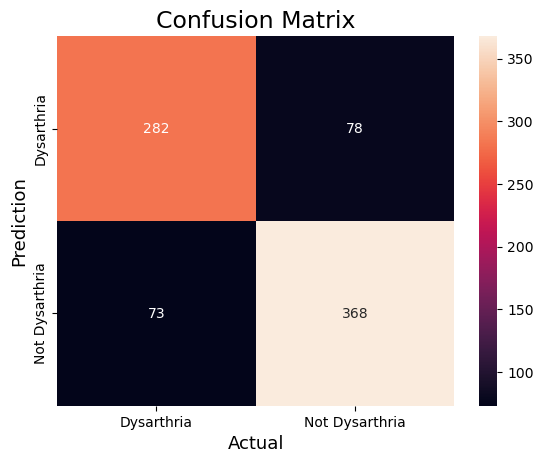

In [35]:
# Full Confusion Matrix
confusionMatrix = [[CM[0][0],CM[2][0]],[CM[1][0],CM[3][0]]]
# [[288,72],[96,326]]
sns.heatmap(confusionMatrix,
            annot=True,
            fmt='g',
            xticklabels=['Dysarthria','Not Dysarthria'],
            yticklabels=['Dysarthria','Not Dysarthria'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()